# Harmonic Frequencies

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.constants as const
import astropy.constants as aconst
from calcwf import gen_wf, peri_advance_orbit, shifted_e, chirp2total

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


## Q transform of an eccentric waveform

Let's first compute the Q transform of an eccentric TEOBResumS waveform in order to see the eccentric harmonics.

In [3]:
# Parameters
f_ref = 10
e = 0.2
f_low = 5
chirp = 10
q = 2

In [4]:
# Gen wf and qtransform
s_e = shifted_e(f_low, f_ref, e)
h = gen_wf(f_low, s_e, chirp2total(chirp,q), q, 1024, 'TEOBResumS')
h_q_times, h_q_freqs, h_q_plane = h.real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(5, 100))
h_q_amp = h_q_plane**0.5

# Normalise amplitude at each freq
h_q_amp = (h_q_amp.T / np.max(h_q_amp, axis=1)).T

# Cut data before -10.5 seconds
h_q_amp = h_q_amp[:, h_q_times>=-10.5]
h_q_times = h_q_times[h_q_times>=-10.5]

# Get evolution of f_gw by maximum power at each timestep
t_arr = h_q_times[:-25:10]
f_gw = h_q_freqs[np.argmax(h_q_amp, axis=0)[:-25:10]]
f_gw = np.convolve(f_gw, np.ones(11), "valid")/11
t_arr = t_arr[5:-5]

Text(0, 0.5, 'Frequency / Hz')

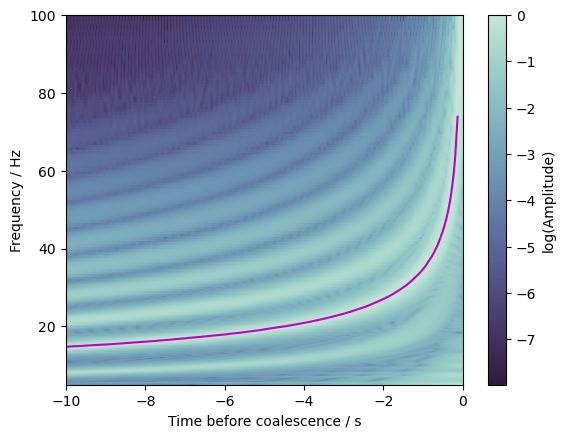

In [5]:
# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(h_q_times, h_q_freqs, np.log10(h_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot frequency track
plt.plot(t_arr, f_gw, c='m')

# Plot formatting
plt.ylim(5,100)
plt.xlim(-10, 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

The amplitude here is normalised such that the highest amplitude at any given frequency is one. We have also plotted the highest (normalised) amplitude at each time step which traces the fundamental $h_0$ harmonic frequency.

Now we can add both the integer multiple predictions, and our harmonic predictions, based on this $h_0$ harmonic frequency.

In [7]:
# Gets orbital frequency from gravitational wave frequency
def f_orb(f_gw):
    return f_gw/2

# Gets apsidal advance frequency from gravitational wave frequency
def f_ap(f_gw, f_ref, ecc, M):
    P_orb = 1/f_orb(f_gw)
    e = shifted_e(f_gw, f_ref, ecc)
    peri_advance_per_orb = peri_advance_orbit(P_orb, e, M*aconst.M_sun.value)
    P_ap = P_orb*2*np.pi/peri_advance_per_orb
    return 1/P_orb - 1/P_ap

In [8]:
# Frequencies of harmonics assuming integer multiples of orbital freq
def int_harm_freqs(f_gws, ks):

    # Calculate frequencies
    freqs = []
    for k in ks:
        if k != 0:
            f_harm = (2+k)*f_orb(f_gws)
            freqs.append(f_harm)

    return freqs

# Frequencies of harmonics using apsidal advance frequency
def ap_harm_freqs(f_gws, ks, f_ref, ecc, M):

    # Calculate frequency components
    f_orbs = f_orb(f_gws)
    f_aps = f_ap(f_gws, f_ref, ecc, M)

    # Calculate frequency for each harmonic
    freqs = []
    for k in ks:
        if k != 0:
            f_harm = 2*f_orbs + k*f_aps
            freqs.append(f_harm)

    return freqs

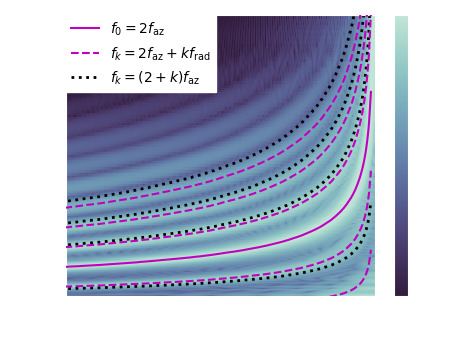

In [8]:
plt.figure(figsize=(0.75*6.4,0.75*4.8))
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

# Make qtransform plot
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(h_q_times, h_q_freqs, np.log10(h_q_amp), rasterized=True, cmap=cmap, vmin=-6)
plt.colorbar(label='log(Amplitude)')

# Plot frequency track
plt.plot(t_arr, f_gw, c='m', zorder=5, label="$f_0 = 2f_\mathrm{az}$")

# Plot our harmonic frequency predictions
harm_freqs = ap_harm_freqs(f_gw, np.arange(-2, 4), f_low, s_e, chirp2total(chirp, q))
for i, harm_freq in enumerate(harm_freqs):
    plt.plot(t_arr, harm_freq, c='m', ls='dashed', zorder=3, label="$f_k = 2f_\mathrm{az} + kf_\mathrm{rad}$" if i == 0 else "")

# Plot integer harmonic frequency predictions
harm_freqs = int_harm_freqs(f_gw, np.arange(-2, 4))
for i, harm_freq in enumerate(harm_freqs):
    plt.plot(t_arr, harm_freq, c='k', ls='dotted', zorder=1, lw=2, label="$f_k = (2+k)f_\mathrm{az}$" if i == 0 else "")

# Plot formatting
plt.yticks(list(plt.yticks()[0]) + [5])
plt.ylim(5,100)
plt.xlim(-10, 0)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')
plt.legend(loc='upper left', bbox_to_anchor=(0,1), fancybox=False, framealpha=1, borderaxespad=0, edgecolor='w', labelcolor='k', facecolor='w')
plt.tight_layout()
plt.savefig('Figures/qtransform.png', dpi=450, transparent=True)

It is clear from this plot that including the effects of apsidal advance (our harmonic predictions) is crucial to accurately describing the evolution of the harmonic frequencies.

## Relative harmonic frequencies

We can make a plot here of how the harmonic frequencies evolve with gravitational wave frequency ($f_\textrm{gw} = 2f_\textrm{orb}$).

In [2]:
# Find ISCO frequency from total mass
def f_ISCO(M):

    f_ISCO = const.c**3/(6*np.sqrt(6)*np.pi*const.G*M*aconst.M_sun.value)

    return f_ISCO

In [5]:
# Parameters
harmonics = np.arange(-3, 6)
ecc = 0.2
f_ref = 10
M = chirp2total(10, 2)
f_match = 20

# Calculating parameters
f_high = f_ISCO(M)
fs = np.linspace(f_match, f_high, 1001)[1:]

In [13]:
# Draw frequency evolution of harmonics
def plot_f_harms(ax, ks, f_gws):

    # Get component of frequencies
    f_orbs = f_orb(f_gws)
    f_aps = f_ap(f_gws, f_ref, ecc, M)

    # Get colour order of frequencies
    ks_abs_r = np.abs(ks)[::-1]
    inds = len(ks)-1-np.argsort(ks_abs_r)
    cs = np.zeros(len(inds))
    cs[inds] = np.arange(0, len(inds))

    # Add and plot frequencies for each harmonic
    for c, k in zip(cs, ks):
        f_harms = 2*f_orbs + k*f_aps
        ls, lw = ('solid', 1.5) if c < 4 else ('dotted', 1.5)
        ax.plot(f_gws, f_harms/f_gws, c=f'C{int(c)}', ls=ls, lw=lw)
        if k+2 > 0:
            ax.axhline(0.5*(k+2), c='k', ls='dashed', alpha=0.6, zorder=-1)
        label_x_pos = f_gws[-1] + (f_gws[-1]-f_gws[0])/100
        plt.text(label_x_pos, f_harms[-1]/f_gws[-1], f'$f_{{{k}}}$', va='center')        

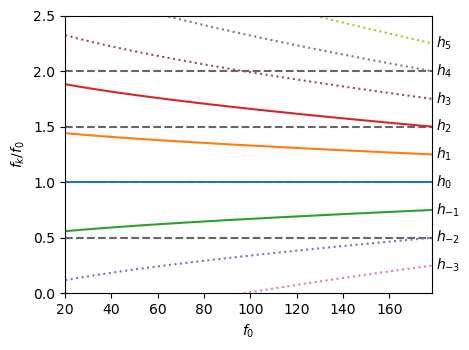

In [14]:
# Make plot
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plot_f_harms(plt.gca(), harmonics, fs)
plt.xlabel('$f_0$')
plt.ylabel('$f_k/f_0$')
plt.xlim(f_match, f_high)
plt.ylim(0, 2.5)
plt.tight_layout()
plt.savefig('Figures/HarmFreqs.png', dpi=450)

The solid lines correspond to harmonics we use in this work.